# Method 2

In [1]:
#imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.cross_validation import  train_test_split
from matplotlib import pyplot
from sklearn import metrics
from sklearn.cross_validation import KFold, cross_val_score
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree
from time import time
from sklearn.preprocessing import StandardScaler

from keras.layers import Dropout


/home/sara/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/sara/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df= pd.read_csv('breast-cancer-wisconsin-data.csv')

In [3]:
df.drop(['Unnamed: 32', 'id'], axis=1, inplace= True)

In [4]:
def categorical_to_numeric_diagnosis(x):
    if x=='M':
        return 1
    if x=='B':
        return 0

In [5]:
df['diagnosis']= df['diagnosis'].apply(categorical_to_numeric_diagnosis)

In [6]:
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [7]:
features = list(df.columns[1:31])

In [8]:
features

['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'symmetry_worst',
 'fractal_dimension_worst']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df['diagnosis'].values, test_size=0.30, random_state=42)

In [10]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 30))
classifier.add(Dropout(rate = 0.1))

# Adding the second hidden layer
classifier.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(rate = 0.1))

# Adding the third hidden layer
classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(rate = 0.1))


# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

classifier.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                992       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
den

In [11]:
import keras
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [12]:
scaler = StandardScaler()

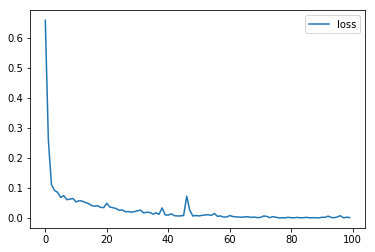

398/398 [==============================] - 2s 5ms/step - loss: 0.0017 - acc: 1.0000


In [13]:
classifier.fit(scaler.fit_transform(X_train.values), np.array(y_train),batch_size = 5,epochs=100,callbacks=[plot_losses])

In [14]:
from keras.models import load_model

classifier.save('breast_cancer_model.h5') #Save trained ANN

In [15]:
y_prediction = classifier.predict_classes(scaler.transform(X_test.values))

171/171 [==============================] - 0s 1ms/step


In [18]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_prediction)
tn, fn, fp, tp=confusion_matrix(y_prediction,y_test).ravel()

print(cm)

accuracy = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print("Accuracy: "+ str(accuracy*100)+"%")

[[107   1]
 [  1  62]]
Accuracy: 98.83040935672514%


In [19]:
sens=tp/(tp+fn)
spec=tn/(tn+fp)
print("Senstivity:",sens)
print("Specificity:",spec)

Senstivity: 0.9841269841269841
Specificity: 0.9907407407407407
